##Lecture 8: 1D Convolutional Networks

Convolution involves sliding a "kernel" function along the data:
\begin{equation}
  y(t) = \int x(t-\tau) h(\tau) d\tau
\end{equation}
and remember that $h$ is running backward, while $x$ is moving forward in this equation.  In discrete time:
\begin{equation}
  y(t) = \sum_\tau x(t-\tau) h(\tau)
\end{equation}
If $h(\tau) = 0 $ whenever $\tau < 0$ then the convolution is "causal" in the sense that it depends only on past values of $x$.

Convolution is a linear operator, in the sense that
\begin{equation}
  h*(x+z) = h*x + h*z
\end{equation}
so this means that it can be represented by a matrix operation:
\begin{equation}
  h*x \sim Wx
\end{equation}
where the matrix $W$ is a "Toeplitz" matrix which means that all the diagonals are constant:
\begin{equation}
 Wx \sim  \left[
     \begin{array}{c}
     y_0 \\ y_1 \\ y_2 \\ y_3 \\y_4
     \end{array}
     \right] = \left[
   \begin{array}{ccccc}
   1 & .5 & 0 & 0 & 0\\
   .5 & 1 & .5 & 0 & 0 \\
   0 & .5 & 1 & .5 & 0 \\
   0& 0 & .5 & 1 & .5  \\
   0 & 0 & 0 & .5 & 1 \\
   \end{array} \right]
   \cdot
   \left[
     \begin{array}{c}
     x_0 \\ x_1 \\ x_2 \\ x_3 \\x_4
     \end{array}
     \right]
      \\
\end{equation}

which corresponds to $h = <0.5, 1, 0.5>$.  The matrix $W$ corresponds to a causal filter if all values above the diagonal are zero.  


Math Moment: If we allow elements that slide off one side of the matrix to re-enter the other side, then we have a "circulant matrix":
\begin{equation}
 \left[
   \begin{array}{ccccc}
   1 & .5 & 0 & 0 & 0.5\\
   .5 & 1 & .5 & 0 & 0 \\
   0 & .5 & 1 & .5 & 0 \\
   0& 0 & .5 & 1 & .5  \\
   0.5 & 0 & 0 & .5 & 1 \\
   \end{array} \right]
   \end{equation}
and it is worth noting that the eigenvectors of a circulant matrix are of the form $e^{-2i\pi k/N}$ (sin's and cos's) and the eigenvalues are the Fourier transform of the kernel $h$.


Back to networks:  the difference between a convolution and just a regular linear mapping is the constraint that the rows are all the same except shifted by one.

When we do this in a network, there may be a nonlinearity
\begin{equation}
  y = \sigma(Wx)
\end{equation}
so the only difference between a convolutional network and a regular network is whether or not $W$ is constrained to be Toeplitz.  

A network with multiple outputs might have
\begin{equation}
  y = <h_0 *x,\ldots , h_N*x> \\
   = <W_0x, \ldots, W_Nx>
\end{equation}

To make this more confusing, although we usually think of $x(t)$ as a scalar, for convolutional networks it is better to think of $x(t)$ as a vector $<x_0(t), \ldots, x_M(t)>$ so that there is a vector input at each time point.  Unlike how convolution is used for filtering where we run the convolution over all time, in this case, the convolution is run over the vector $x(t)$ at the current time.  In other words, $y(t) = Wx(t)$ at each point in time, or for multiple outputs we have
\begin{equation}
  y(t) = <W_0x(t),\ldots, W_Nx(t)>
\end{equation}
where each matrix $W_j$ is $N \times M$.  For instance, if $x(t)$ is a 100-element vector at each point in time, and if there are 4 different convolutions being run at each point in time, then $y(t)$ has 400 elements $y_{ij}(t)$ at each point in time, where $y_{ij}$ is the $j'th$ point in the convolution given by $W_i$.

If we want a single scalar output $z(t)$ at each time, then we might add another layer to the network:
\begin{equation}
  z(t) = \sigma \left( \sum_{i=0}^M \sum_{j=0}^N v_{ij} \sigma (y_{ij}) \right)
\end{equation}

Why would we use the convolution constraint on the weights?  Here are some reasons:
1. Training is faster because there are fewer weights to train.
2. The network does the same thing at each point in time (within the $x(t)$ vector), which makes sense for time-invariant systems.
3. Forward propagation is faster because it can use convolution operations and does not have to store as many weights.
4. In some cases, we can speed things up using Fourier transforms.





In [12]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import tensorflow as tf

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

# Filtering EMG again
We will use the EMG/force dataset again here so that we can compare with the nonlinear filter.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


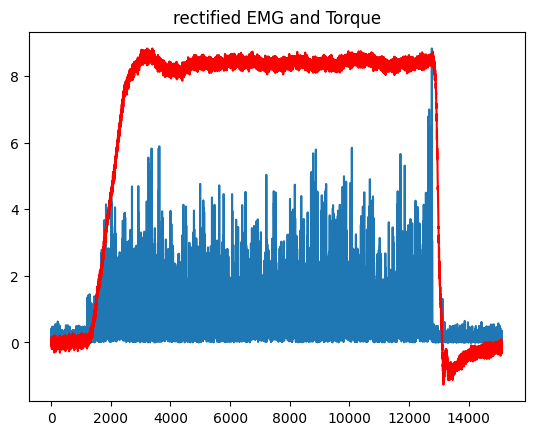

In [14]:
#load the sample EMG data
arEMG = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EMGdata.csv')
dfEMG = pd.DataFrame(arEMG)
ws = dfEMG['Torque'].to_numpy()
ws = ws - ws[0:200].mean()  #use the first few points to find zero
ms = dfEMG['Biceps'].to_numpy()
ms = ms - ms[0:200].mean()  #use the first few points to find zero
ms = np.absolute(ms)  #rectify the EMG
time_points = len(ws)

#scale the range this time => to use raw data as input to the network
#already removed the means; just scale so standard deviation is 1
modulated_signal = ms / np.std(ms)
wave_signal = ws / np.std(ws)

plt.figure()
plt.plot(modulated_signal)
plt.plot(wave_signal * modulated_signal.max()/wave_signal.max(),'r')
plt.title('rectified EMG and Torque');


#Model1: Distributed output

For the first try, use the distributed encoding that we used last time, although this is a very different type of filter.

<Figure size 1400x100 with 0 Axes>

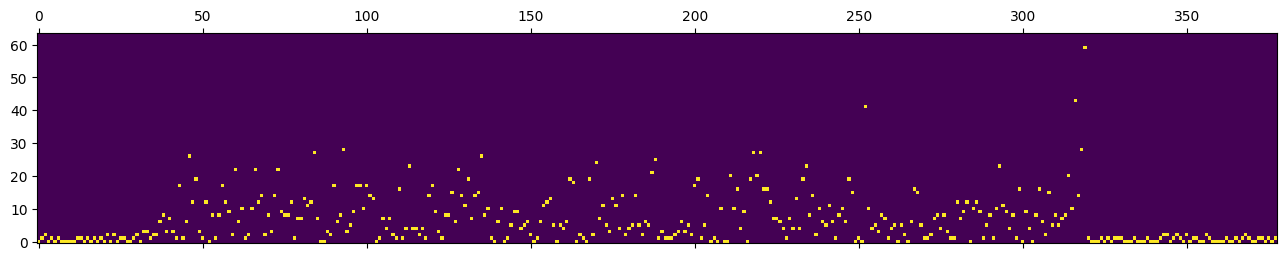

<Figure size 1400x100 with 0 Axes>

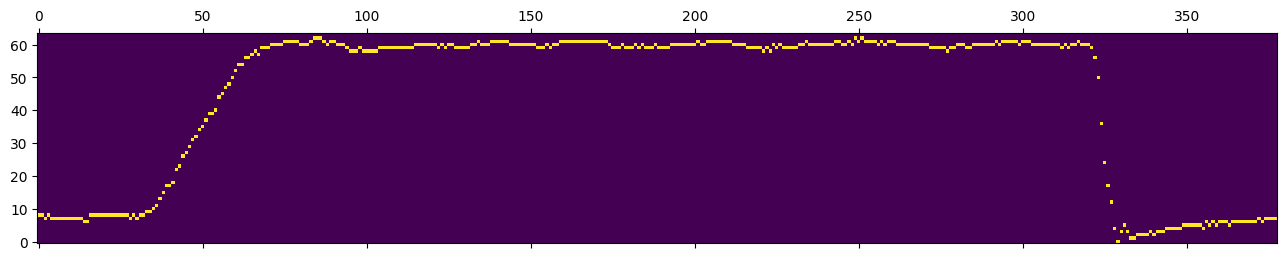

In [ ]:
#encode the state in a state vector representing the probabilities.
#These are the actual measured states, so prob=1 for the correct state
#some people use the term "one-hot" for this type of encoding,
#based on concepts from commercial electrical wiring
def to_distributed(data, nstates=128, timepoints=1000):
  d = data - min(data)
  dscale = ((nstates-1)*d/np.max(d))
  vec = np.zeros((timepoints, nstates), dtype = int)
  vec[np.arange(timepoints),dscale.astype(int)] = 1
  return vec

#turn into probability vectors
#only going to use this for the output;
#do not need to encode the input for this type of network
n_states = 64   #this is arbitrary. sets the precision
vModulated = to_distributed(modulated_signal, n_states, time_points)
dfModulated = pd.DataFrame(data=vModulated, index=np.arange(time_points))
plt.figure(figsize=(14,1))
plt.matshow(vModulated[np.arange(0,time_points,40)].transpose(),origin = 'lower')
vWave = to_distributed(wave_signal, n_states, time_points)
dfWave = pd.DataFrame(data=vWave, index=np.arange(time_points))
plt.figure(figsize=(14,1))
plt.matshow(vWave[np.arange(0,time_points,40)].transpose(), origin = 'lower');

For convolutional networks, the input $x(t)$ at each time $t$ is a vector, and the convolution will run along this vector (not along the time axis).  However, in this case each $x(t)$ is going to be a short window of the actual input time series $s(t)$.  In other words, we will set $x(t) = <s(t), s(t-1), \ldots, s(t-N)>$ at each time.  $x(t)$ then "slides" along the actual input data.

This is exactly what we have done in the past when we created FIR filters. TimeSeriesGenerator does this for us, providing lagged values of the input series as the network inputs.  The difference here is that we have a different calculation being done on the lagged series.  Whereas an FIR filter simply takes the dot product of the input with a filter vector $y(t) = f \dot x(t)$, a convolutional network has an intermediate multivariate layer $y_i(t) = h_i*x(t)$ where each $y_i(t)$ is a vector of the same length as $x(t)$.  Then there is an output layer that combines the values of $y_{ij}(t)$ to produce the final network output $z(t) = \sigma \left(\sum_{ij} \sigma (y_{ij}(t)) \right)$.

In [ ]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 40  #pl means the same as always
predict_point = 20   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)


(1, 40)

In [ ]:
#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 5 #how many time points in the convolution kernel h
n_conv_units = 20   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 36, 20)         │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        46,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,264 (180.72 KB)

 Trainable params: 46,264 (180.72 KB)

 Non-trainable params: 0 (0.00 B)

The number of conv1d parameters is n_conv_units * len_conv_window + len_conv_units (bias) = 20 * 5 + 20.  Note that it does NOT depend on predict_length, because the weights are the same for every point in predict_length.  The reason that the length of the output is 36 instead of 40 is that the convolution requires 5 inputs, so the last 4 outputs are not valid.  In general, the time length of the output of a convolution is predict_length - len_conv_window + 1

Epoch 1/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 2.3632
Epoch 2/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.1196
Epoch 3/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0889
Epoch 4/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 2.0482
Epoch 5/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0448


<Axes: >

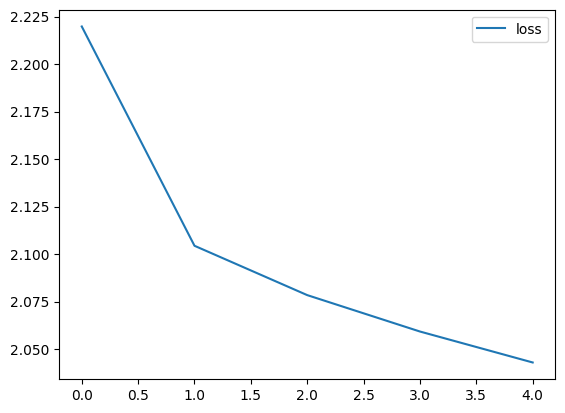

In [ ]:
#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


15076/15076 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step


ML rms_error 0.522782511476801
MMSE rms_error 0.5089898776832219


<Figure size 1400x400 with 0 Axes>

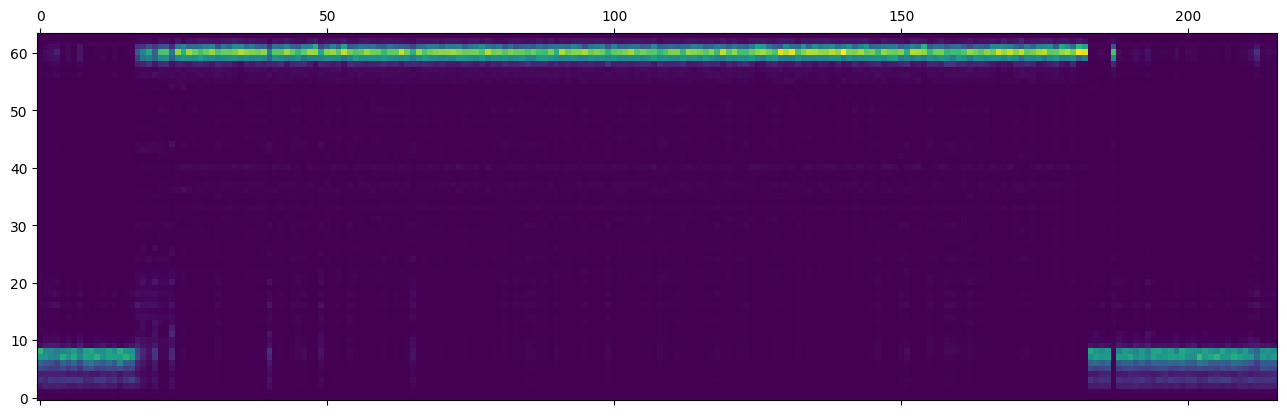

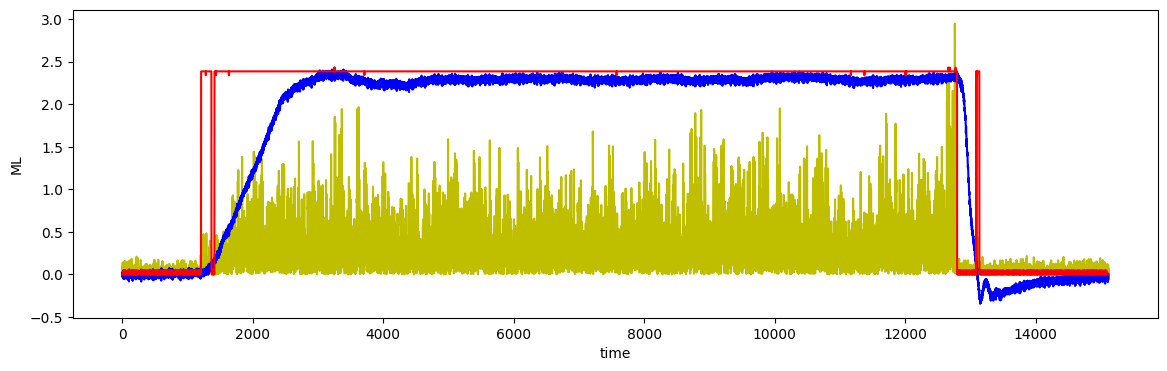

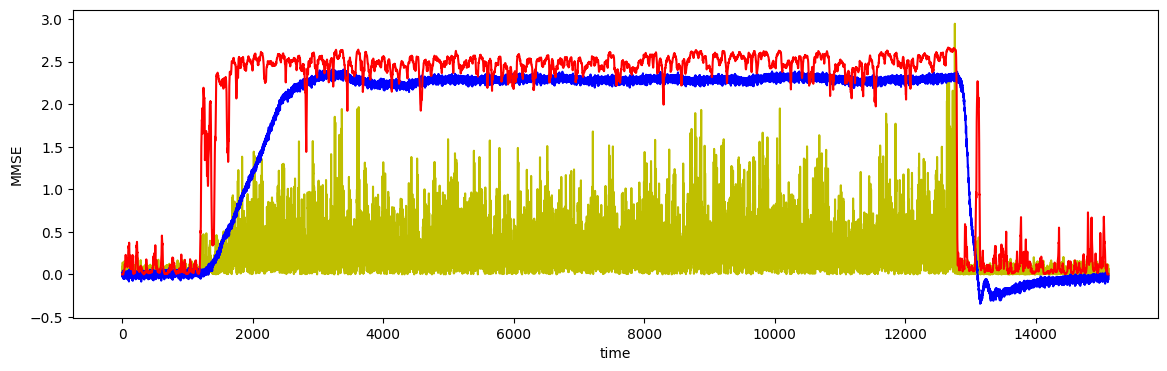

In [ ]:
#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

Note that the ML estimate did much better than the MMSE estimate, or at least seems to have less noise.  This is because the averaging operation is very sensitive to outliers and small fluctuations in the data.  Also, the network was trained using the categorical_crossentropy loss, which means that it was optimized for an ML readout, not an MMSE readout.  

#Model 2: scalar output

So to compare, let's do the same thing again but not using the distributed output.

In [ ]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 40
predict_point = 20
batch_size = 1
#only difference here is that the output target is a scalar value rather than distributed
#still have to insert some zeros in order to have a non-causal filter
target = np.insert(wave_signal,0,np.zeros(predict_point))
generator = TimeseriesGenerator(modulated_signal, target[0:len(modulated_signal)],
                                length = predict_length, batch_size=batch_size)
generator[0]

(array([[0.1090124 , 0.13250653, 0.15292461, 0.01174526, 0.2752221 ,
         0.04468212, 0.04314229, 0.03216694, 0.11999135, 0.41793407,
         0.24228524, 0.13096671, 0.04314229, 0.03216694, 0.17487891,
         0.04314229, 0.19683681, 0.13096671, 0.09803345, 0.13250653,
         0.0651002 , 0.09956968, 0.13250653, 0.02272422, 0.01020904,
         0.35053133, 0.15292461, 0.14194566, 0.15446083, 0.01174526,
         0.11999135, 0.15292461, 0.02272422, 0.01174526, 0.05565747,
         0.04314229, 0.15292461, 0.17641873, 0.07761537, 0.47282522]]),
 array([0.04615393]))

In [ ]:
window_size = predict_length
len_conv_window = 5
n_conv_units = 20
n_sensors = 1
model = Sequential()
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))  #note there is only a single (linear) output
model.compile(optimizer='adam', loss='mse')
#in this case, use mse loss because output is scalar and no longer a p(x, t)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 36, 20)         │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           721 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.3783
Epoch 2/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.2184
Epoch 3/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.2191
Epoch 4/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.2133
Epoch 5/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.2020


<Axes: >

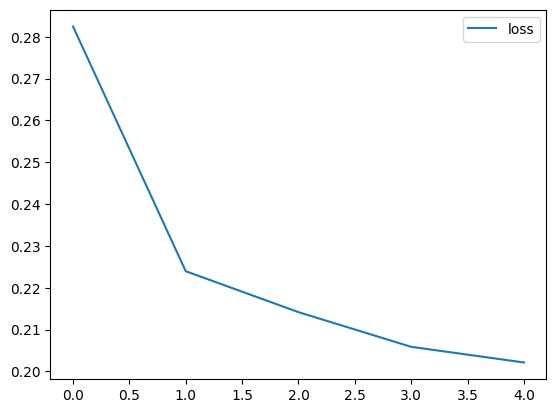

In [ ]:
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


15076/15076 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step


Scalar output rms_error 1.4181005203071435


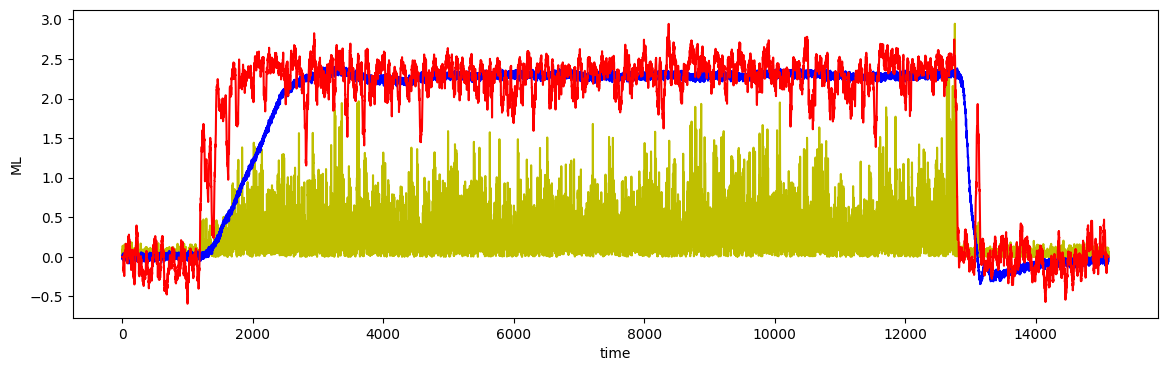

In [ ]:
predict = dfPredict.values #don't have to do ML or MMSE calculation here
#remove the mean
predict -= predict[0:200].mean()
#scale so they print at the same size
predict *= wave_signal.std()/predict.std()

#pad the beginning and end with zeros to make up for the missing ends of the convolution
predict = np.append(predict, np.zeros(predict_point).reshape(predict_point,1), axis=0)
predict = np.append(np.zeros(predict_point).reshape(predict_point,1), predict, axis=0)

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict,'r')
plt.ylabel('ML')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict-wave_signal)))
print('Scalar output rms_error {}'.format(rms_error));

#yellow=emg, blue=true force, red=predicted force

The result looks a lot like the MMSE prediction from before.  That makes sense, because it is basically what the network is trying to do.  Small variations in the input will lead to small variations in the output, so there will always be some noise that gets through.  In an ML readout that does not happen, because finding the index is like a quantizing operation and quantizing rejects small amounts of noise.

#Model 3: Multivariate input

Let's add a second input variable.  By including both the biceps and the triceps, we might have a better estimate of joint torque, because the torque may look like biceps-triceps since they pull in opposite directions. The triceps is not the only force causing elbow extension, and the biceps is not the only force causing elbow flexion, but maybe this would be better by having another variable in the mix.

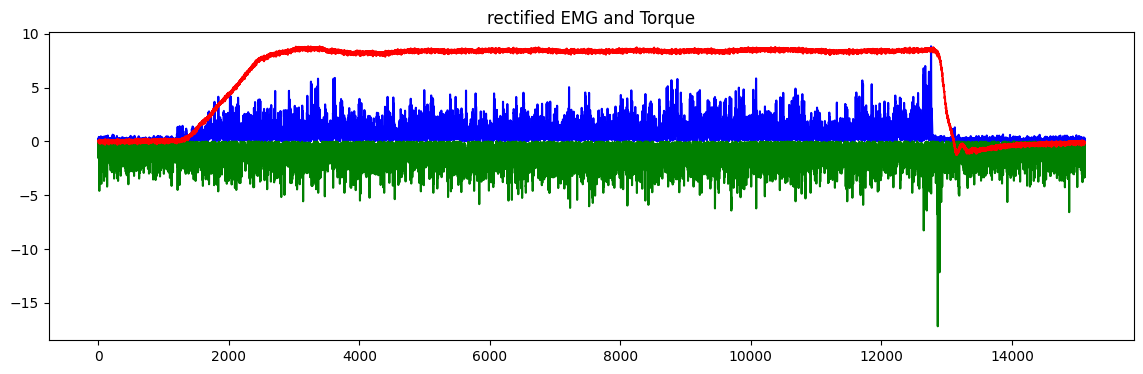

In [ ]:
#extract and normalize the triceps data
ts = dfEMG['Triceps'].to_numpy()
ts = ts - ts[0:200].mean()  #use the first few points to find the zero
ts = np.absolute(ts)  #rectify the EMG
triceps_signal = ts / np.std(ts)
#normalization hides the fact that the amplitude of the triceps is
#much less than the biceps
#as a result, it may amplify the noise. won't matter here,
#but be aware of differences in scale in your own data.

plt.figure(figsize=(14,4))
plt.plot(modulated_signal,'b')
plt.plot(-triceps_signal,'g')
plt.plot(wave_signal * modulated_signal.max()/wave_signal.max(),'r')
plt.title('rectified EMG and Torque');

In [ ]:
predict_length = 40
predict_point = 20
batch_size = 1
dfTarget = dfWave.shift(periods=predict_point,fill_value=0) #as usual, make this noncausal
time_points = len(modulated_signal)
#combine the biceps and triceps data by making them into column vectors
#(using reshape) and then joining them horizontally
#this will create a time x 2 matrix.
dfInput = np.hstack((modulated_signal.reshape(time_points,1), triceps_signal.reshape(time_points,1)))
#use the distributed output here so we can compare the results
generator = TimeseriesGenerator(dfInput, dfTarget.values, length = predict_length, batch_size=batch_size)
generator[0][0].shape   #(batch_size, predict_length, n_sensors)

(1, 40, 2)

In [ ]:
window_size = predict_length
len_conv_window = 5
n_conv_units = 40  #increased number of units because of increased number of inputs
n_sensors = 2  #biceps and triceps
model = Sequential()
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten())
model.add(Dense(n_states, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 36, 40)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        92,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,664 (361.97 KB)

 Trainable params: 92,664 (361.97 KB)

 Non-trainable params: 0 (0.00 B)

You would think that the number of conv1d parameters is n_sensors * n_conv_units * len_conv_window + n_sensors * len_conv_units (bias) = 2 * 20 * 5 + 2 * 20 = 240, but this is not the case; it is actually 440.  The reason is that conv1d builds a 2x5 convolution filter that runs along both of the input dimensions at the same time.  There are 40 outputs, so this is 2x5x40 = 400 weights, plus 40 bias units, to give a total of 440.

Epoch 1/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.3586
Epoch 2/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0492
Epoch 3/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0014
Epoch 4/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0078
Epoch 5/5
15076/15076 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 1.9933


<Axes: >

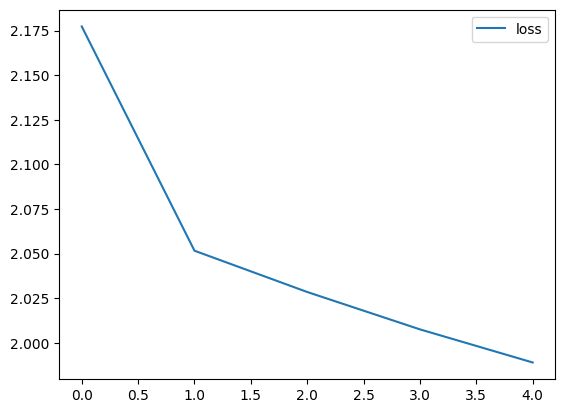

In [ ]:
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


15076/15076 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step


Multivariate ML rms_error 0.5561716823471717
Multivariate MMSE rms_error 0.4845692140429205


<Figure size 1400x400 with 0 Axes>

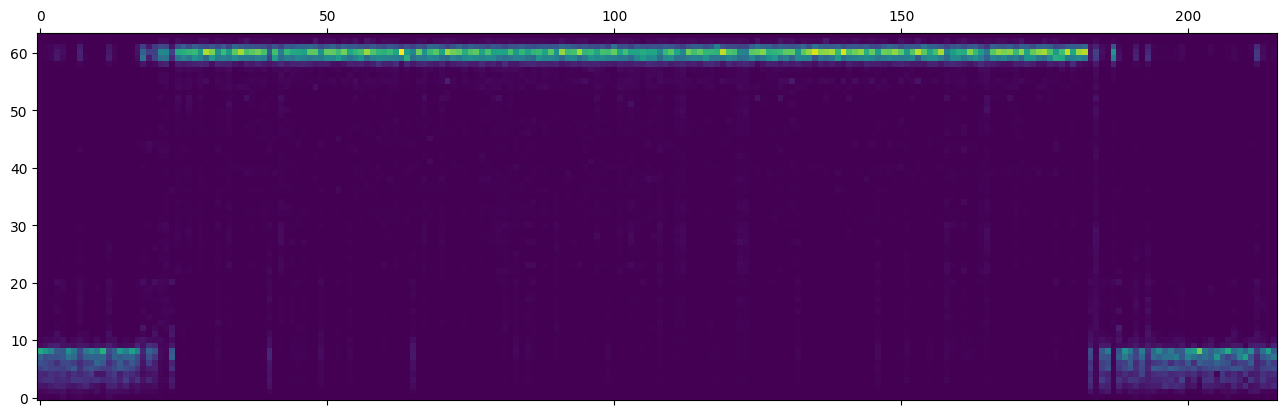

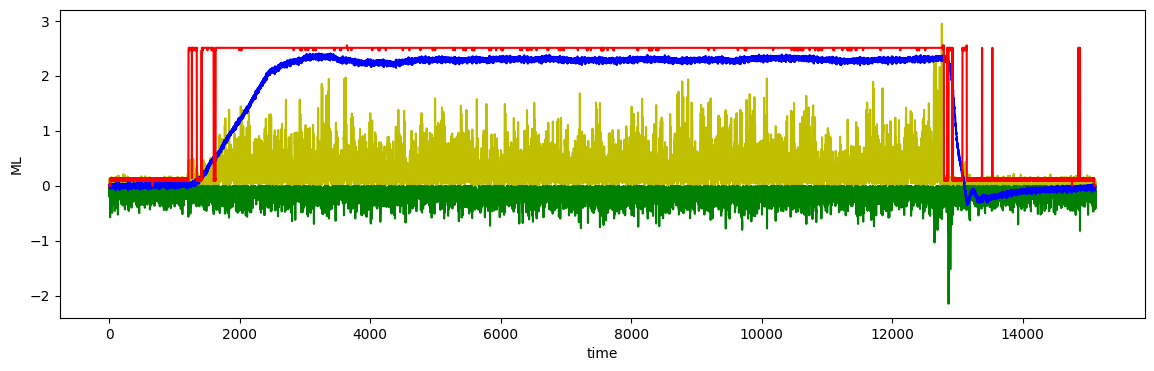

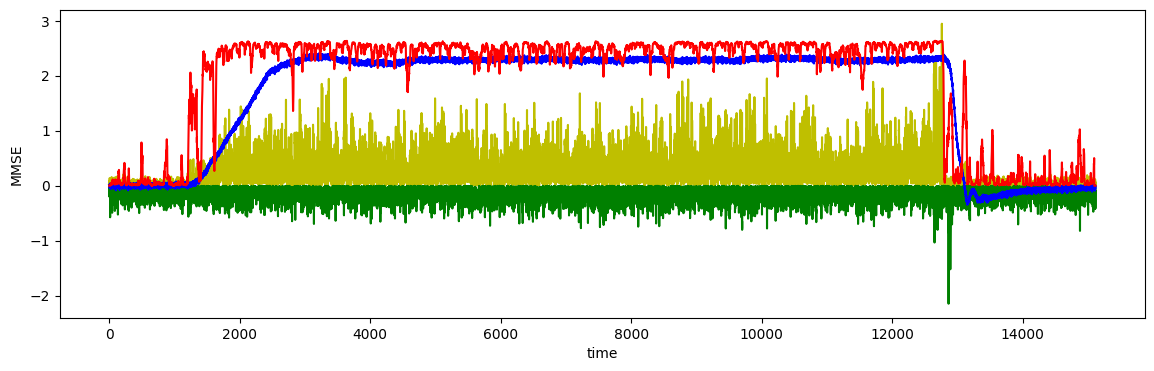

In [ ]:
#used distributed output, so need to convert to a scalar value
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)


plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(-triceps_signal/8,'g')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(-triceps_signal/8,'g')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('Multivariate ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('Multivariate MMSE rms_error {}'.format(rms_error));

#Homework 5

Re-run model #1 above with varying values of
window_size:  10, 30, 40
len_conv_window: 2, 10, 20
n_conv_units: 5, 10, 50

Not all combinations will work, and you do not have to use these exact numbers.  Try to get a sense of how the results vary based on the different values, and make a table of the ML and MMSE estimate rms_error for at least 9 different cases.  What conclusions can you draw from the results?

submit the figures for at least 4 different cases, as well as the table, together in a pdf.

Also: please do not submit files in zip or rar archives; please submit and upload everything as separate files.


# Section Doesn't Change for HW

<Figure size 1400x100 with 0 Axes>

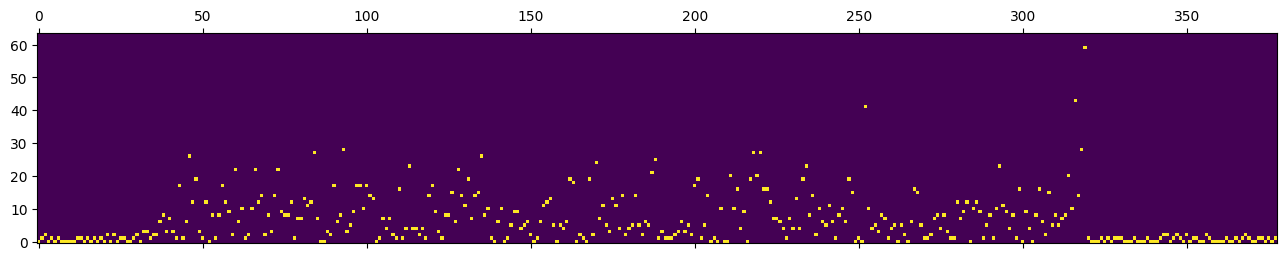

<Figure size 1400x100 with 0 Axes>

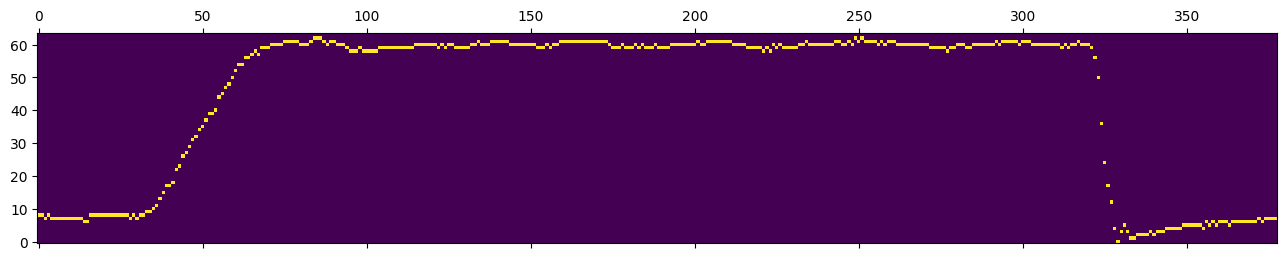

In [15]:
#encode the state in a state vector representing the probabilities.
#These are the actual measured states, so prob=1 for the correct state
#some people use the term "one-hot" for this type of encoding,
#based on concepts from commercial electrical wiring
def to_distributed(data, nstates=128, timepoints=1000):
  d = data - min(data)
  dscale = ((nstates-1)*d/np.max(d))
  vec = np.zeros((timepoints, nstates), dtype = int)
  vec[np.arange(timepoints),dscale.astype(int)] = 1
  return vec

#turn into probability vectors
#only going to use this for the output;
#do not need to encode the input for this type of network
n_states = 64   #this is arbitrary. sets the precision
vModulated = to_distributed(modulated_signal, n_states, time_points)
dfModulated = pd.DataFrame(data=vModulated, index=np.arange(time_points))
plt.figure(figsize=(14,1))
plt.matshow(vModulated[np.arange(0,time_points,40)].transpose(),origin = 'lower')
vWave = to_distributed(wave_signal, n_states, time_points)
dfWave = pd.DataFrame(data=vWave, index=np.arange(time_points))
plt.figure(figsize=(14,1))
plt.matshow(vWave[np.arange(0,time_points,40)].transpose(), origin = 'lower');

# Window Size = 10, conv_window = 2, conv_units = 5

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 5)           │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,959 (11.56 KB)

 Trainable params: 2,959 (11.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15106/15106 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.4636
Epoch 2/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.1426
Epoch 3/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 2.1210
Epoch 4/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.1362
Epoch 5/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.1004
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5670466636816323
MMSE rms_error 0.6214550562669203


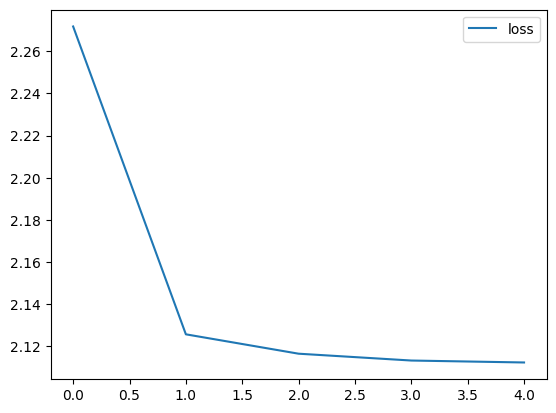

<Figure size 1400x400 with 0 Axes>

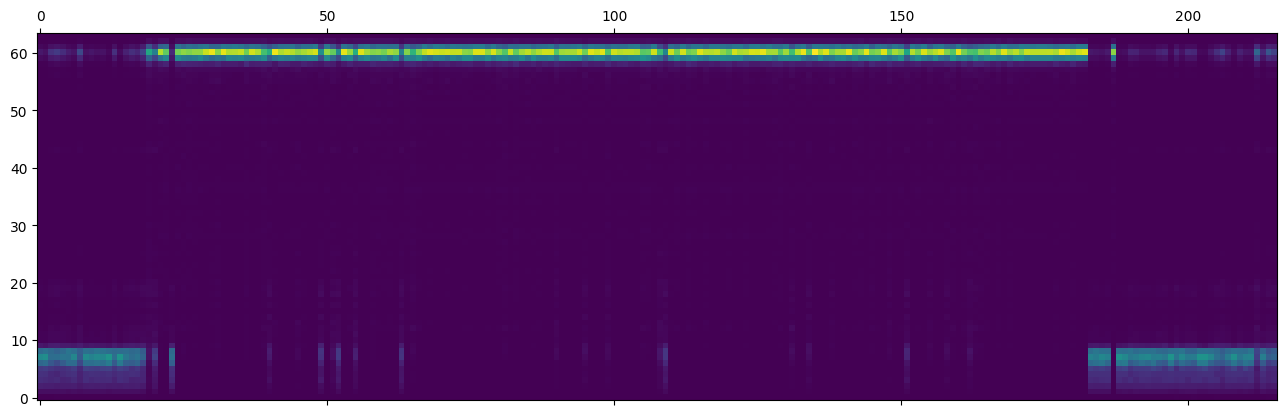

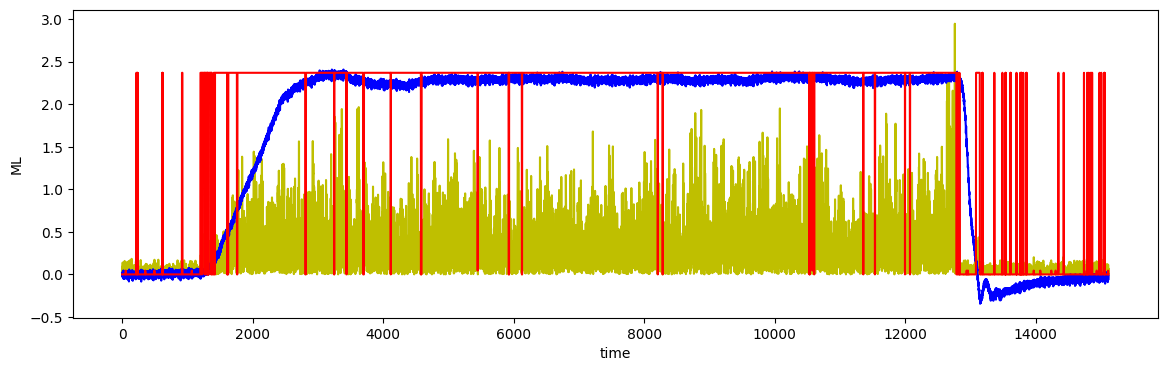

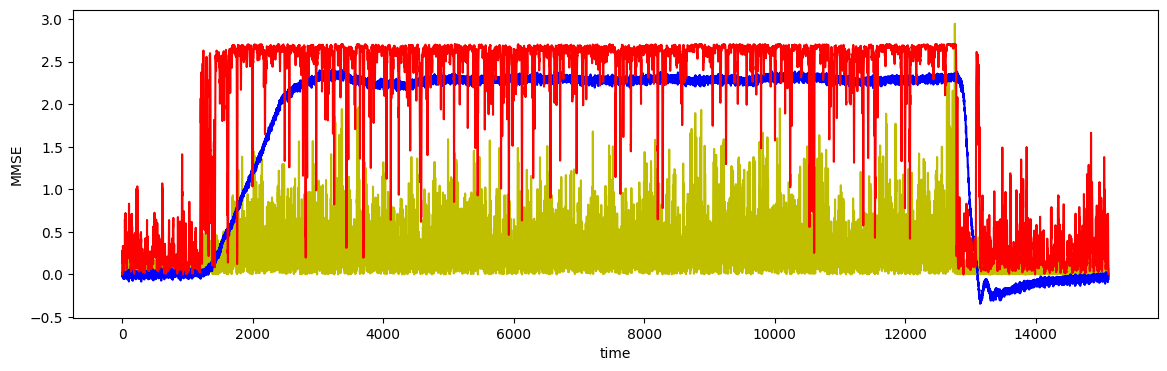

In [5]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 10  #pl means the same as always
predict_point = 5   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 5   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 10, conv_window = 2, conv_units = 10

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 9, 10)          │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         5,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,854 (22.87 KB)

 Trainable params: 5,854 (22.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15106/15106 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 2.3832
Epoch 2/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 2.1439
Epoch 3/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.1359
Epoch 4/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2.1225
Epoch 5/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.1103
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
ML rms_error 0.5645099350361185
MMSE rms_error 0.6091530199143353


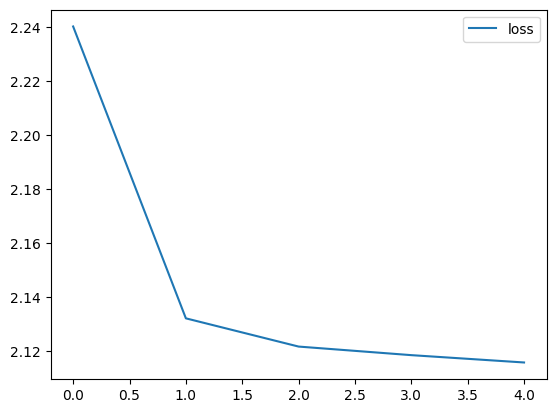

<Figure size 1400x400 with 0 Axes>

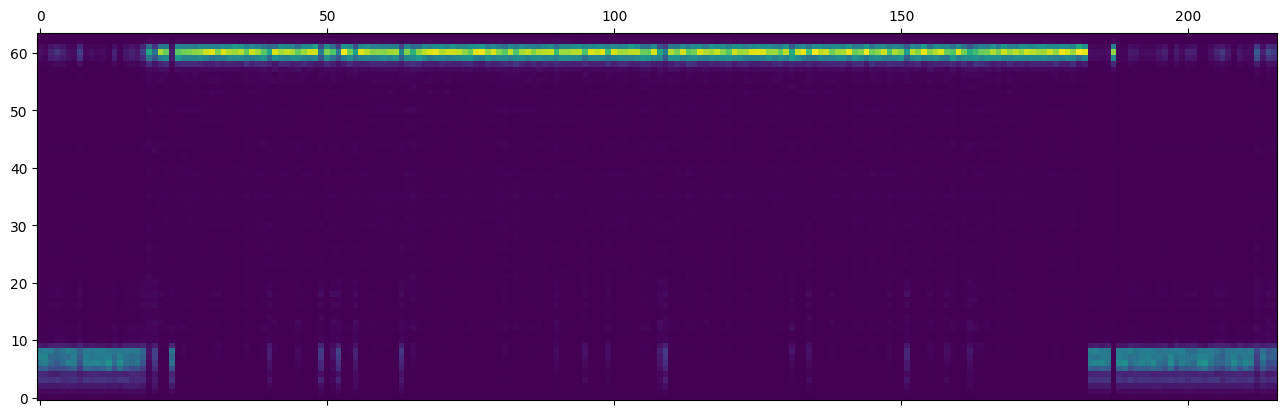

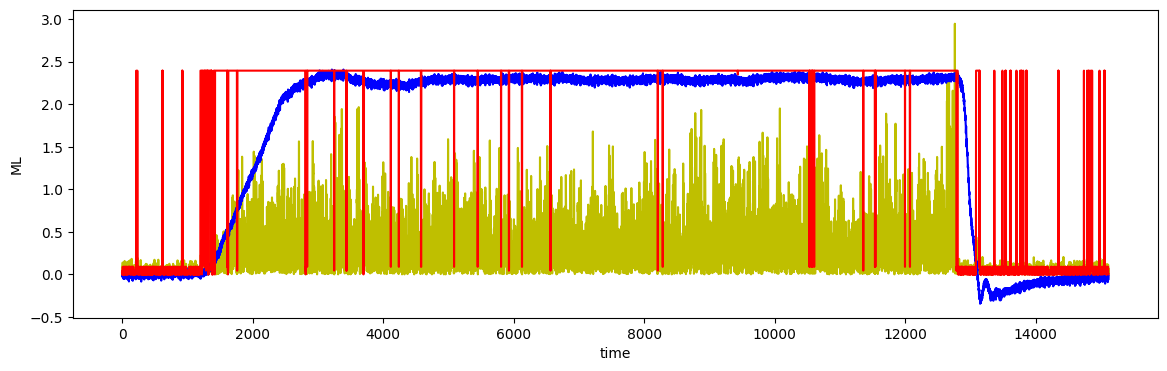

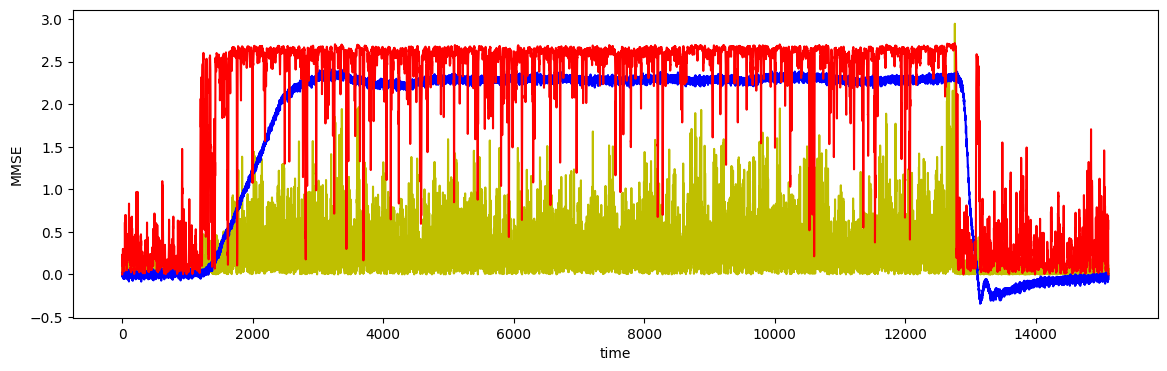

In [6]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 10  #pl means the same as always
predict_point = 5   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 10, conv_window = 2, conv_units = 40

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 9, 40)          │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        23,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,224 (90.72 KB)

 Trainable params: 23,224 (90.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15106/15106 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2.4235
Epoch 2/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 2.1472
Epoch 3/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 2.1574
Epoch 4/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.1302
Epoch 5/5
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0986
15106/15106 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
ML rms_error 0.5943780148204911
MMSE rms_error 0.6830669233420763


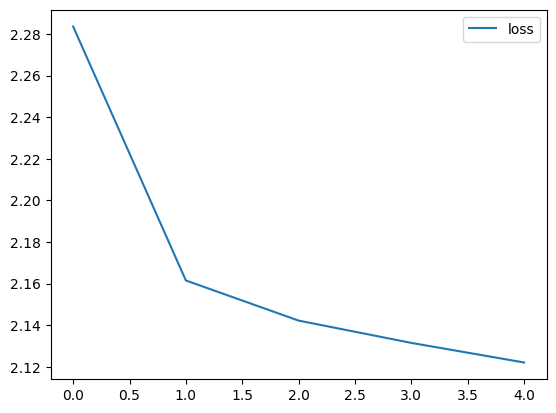

<Figure size 1400x400 with 0 Axes>

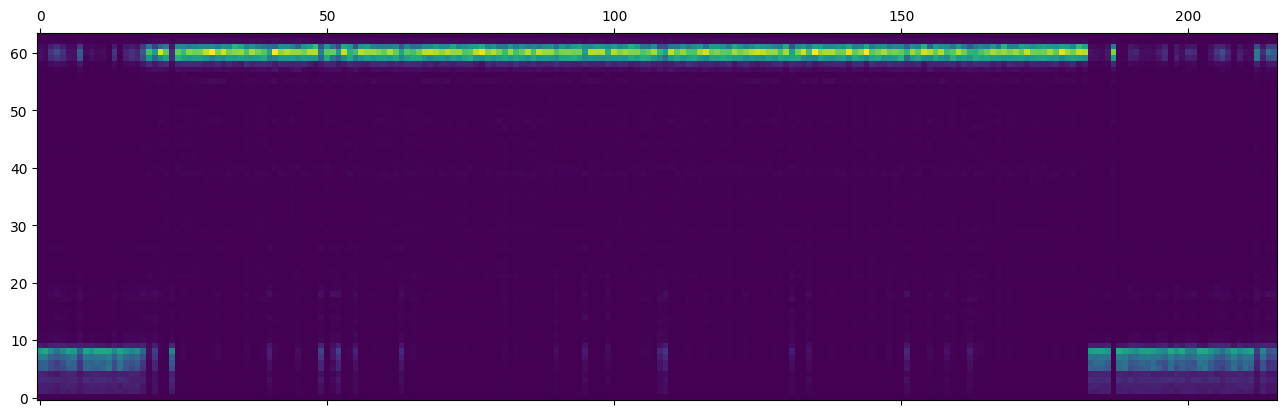

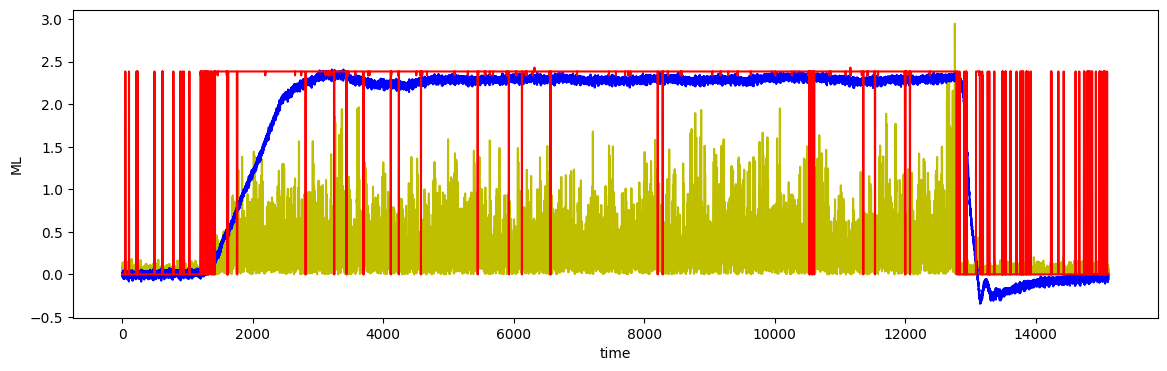

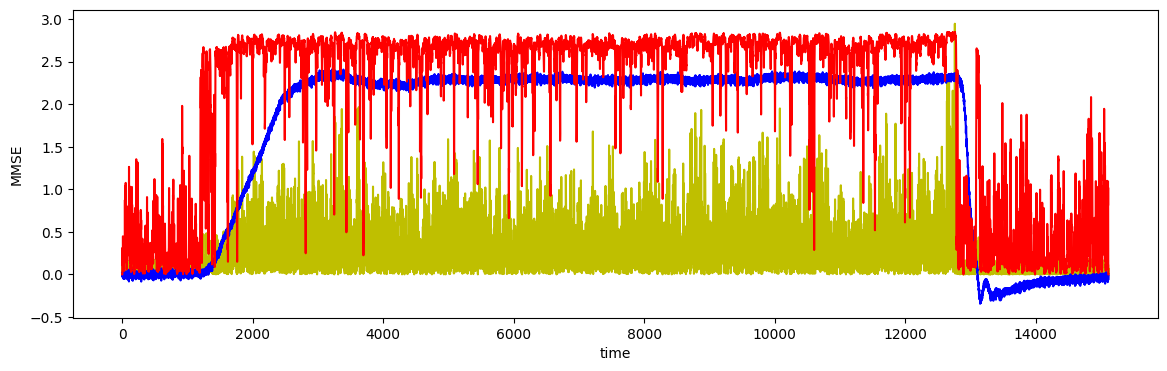

In [7]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 10  #pl means the same as always
predict_point = 5   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 40   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 30, conv_window = 2, conv_units = 10

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 29, 10)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 290)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        18,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,654 (72.87 KB)

 Trainable params: 18,654 (72.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15086/15086 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.3191
Epoch 2/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.1094
Epoch 3/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0706
Epoch 4/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0745
Epoch 5/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0397
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5296118344480012
MMSE rms_error 0.5085237258049822


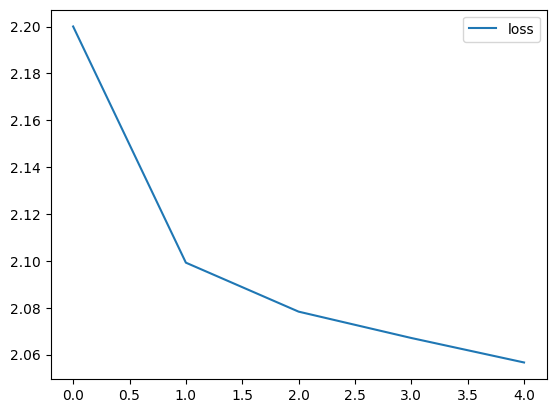

<Figure size 1400x400 with 0 Axes>

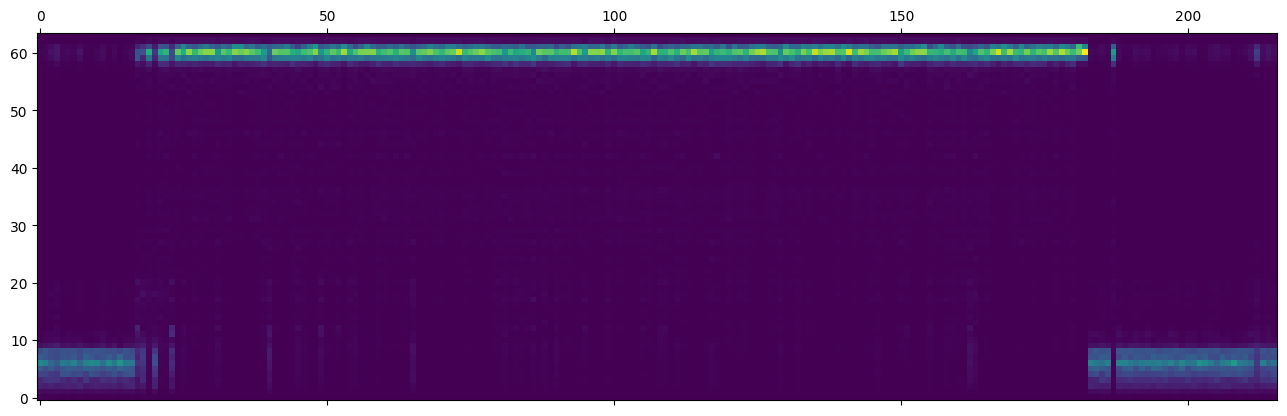

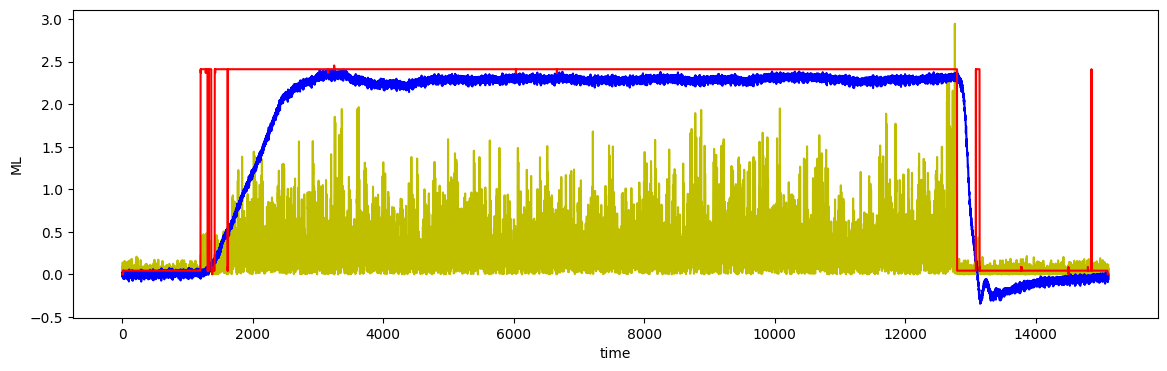

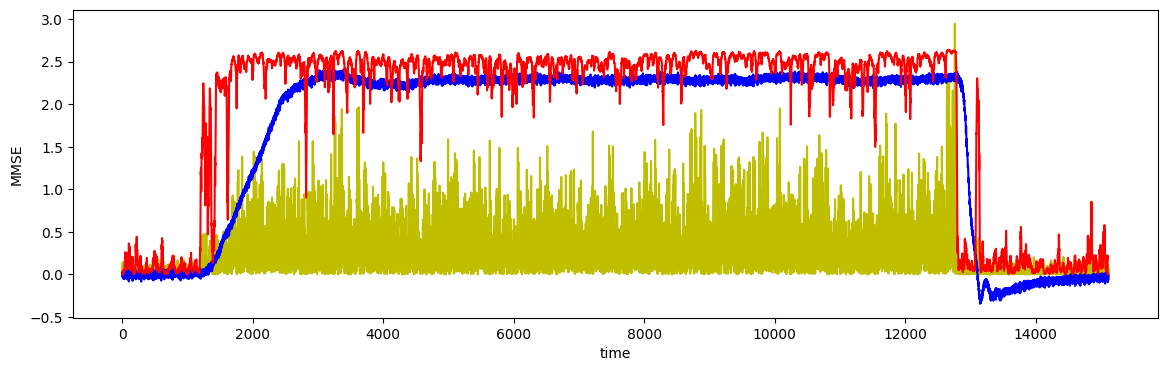

In [17]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 30  #pl means the same as always
predict_point = 15   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 50, conv_window = 2, conv_units = 10

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 49, 10)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 490)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        31,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,454 (122.87 KB)

 Trainable params: 31,454 (122.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 2.3881
Epoch 2/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0993
Epoch 3/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0329
Epoch 4/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0420
Epoch 5/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0160
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5078875305485181
MMSE rms_error 0.47061709197167656


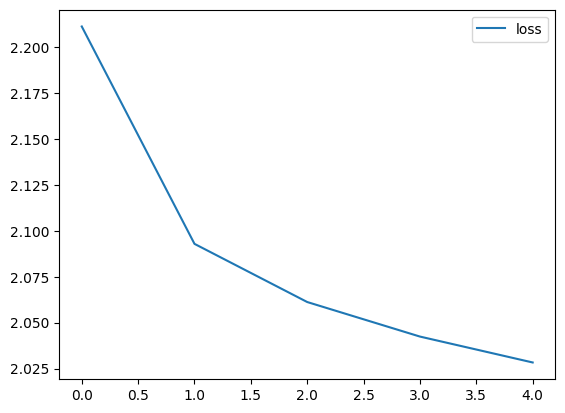

<Figure size 1400x400 with 0 Axes>

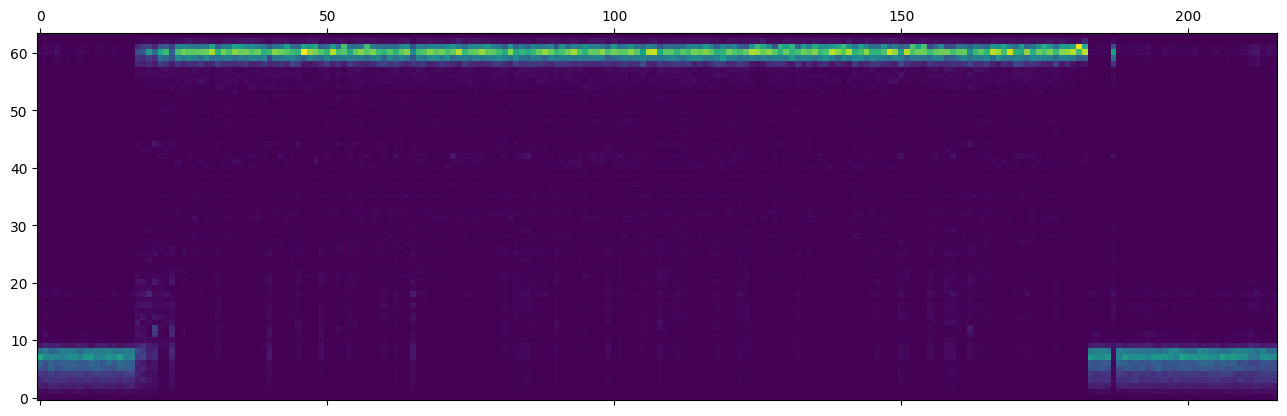

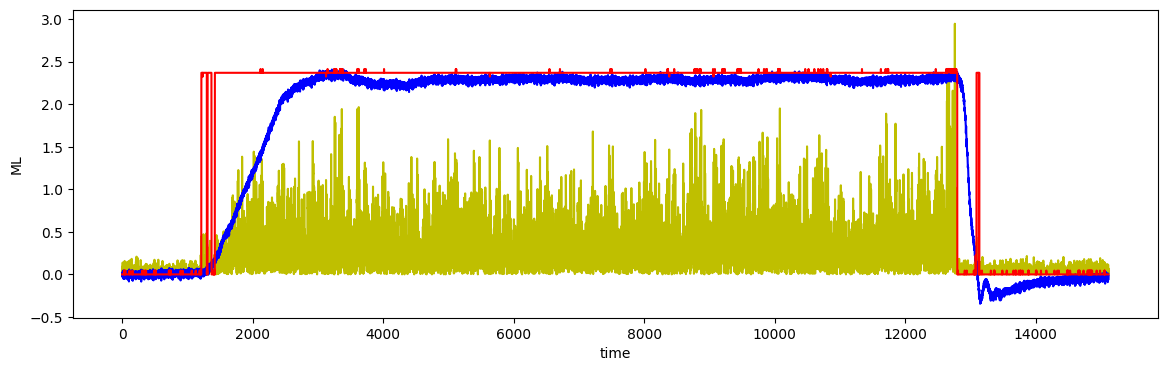

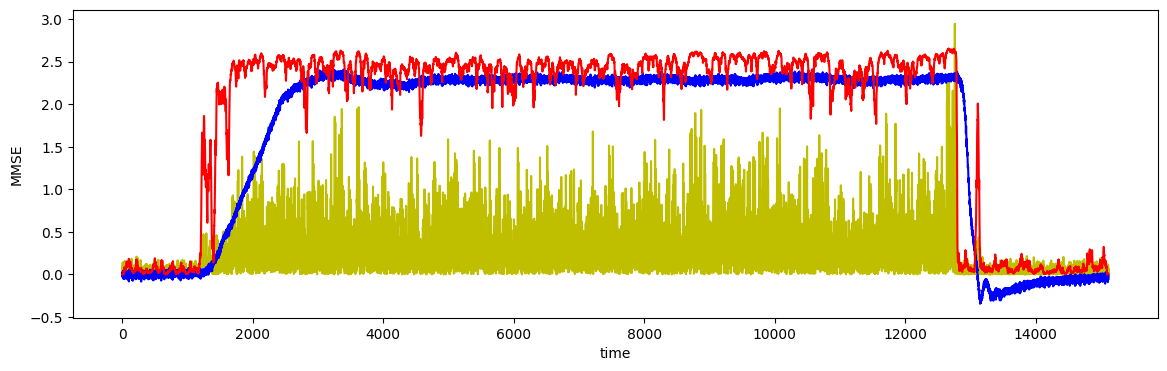

In [19]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 50  #pl means the same as always
predict_point = 25   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 30, conv_window = 4, conv_units = 10

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 27, 10)         │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        17,344 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,394 (67.95 KB)

 Trainable params: 17,394 (67.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.3470
Epoch 2/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.1229
Epoch 3/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0965
Epoch 4/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0545
Epoch 5/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0627
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5222437198417802
MMSE rms_error 0.5256732977941667


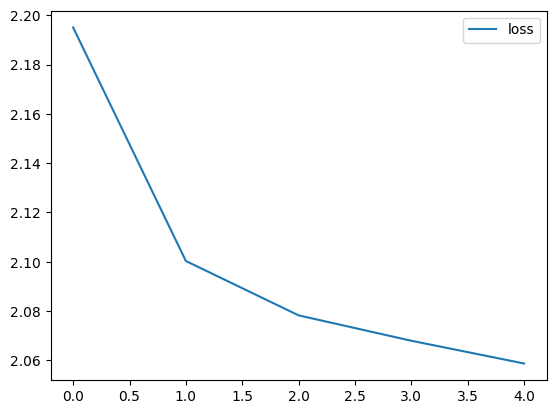

<Figure size 1400x400 with 0 Axes>

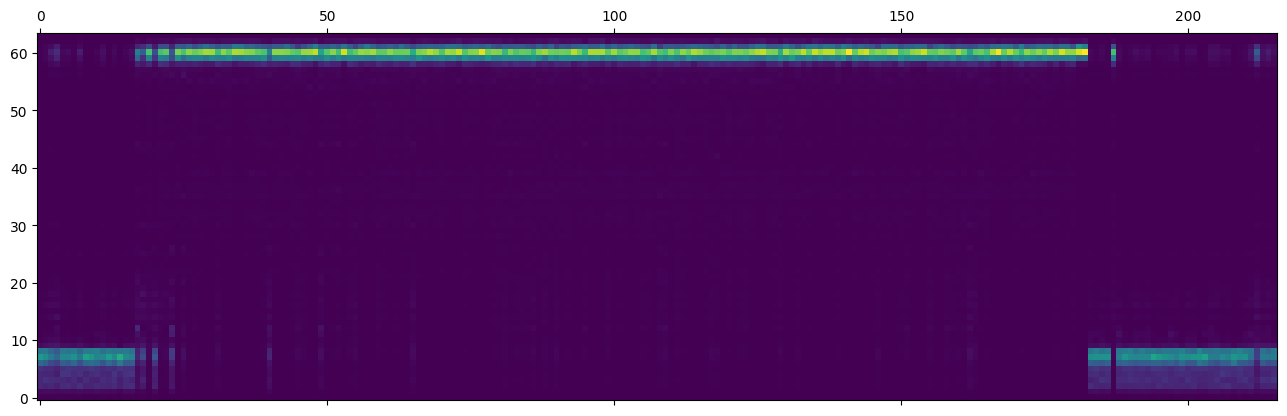

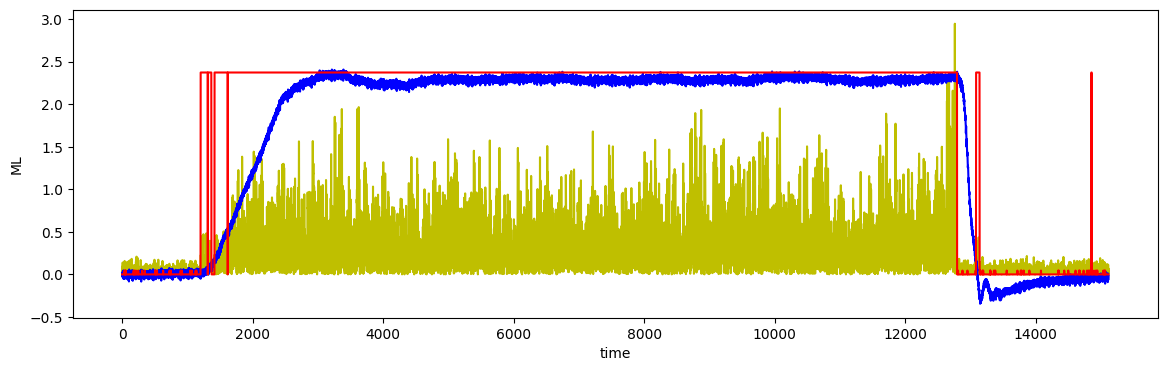

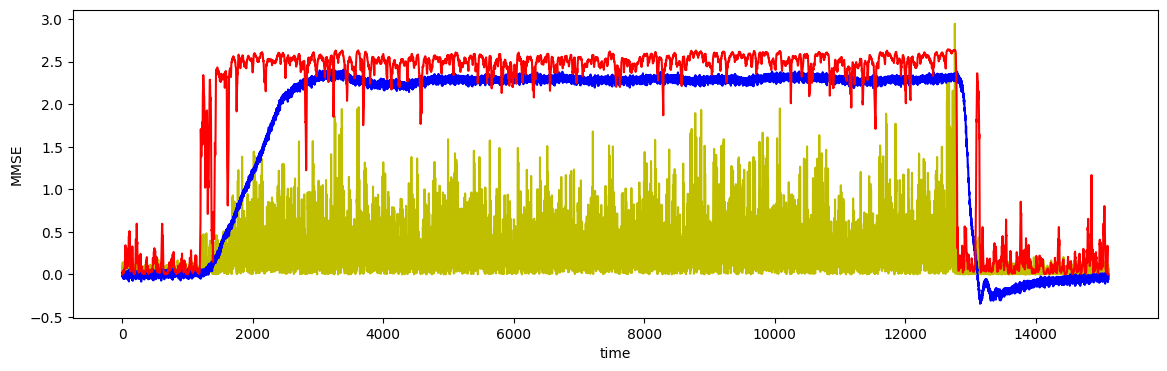

In [20]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 30  #pl means the same as always
predict_point = 15   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 4 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 30, conv_window = 8, conv_units = 10

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 23, 10)         │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 230)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        14,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,874 (58.10 KB)

 Trainable params: 14,874 (58.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15086/15086 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.2927
Epoch 2/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.1091
Epoch 3/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0696
Epoch 4/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 2.0830
Epoch 5/5
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0602
15086/15086 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
ML rms_error 0.5228709208370089
MMSE rms_error 0.4936629749728331


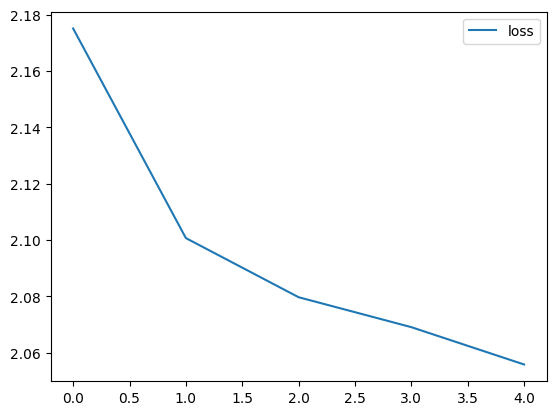

<Figure size 1400x400 with 0 Axes>

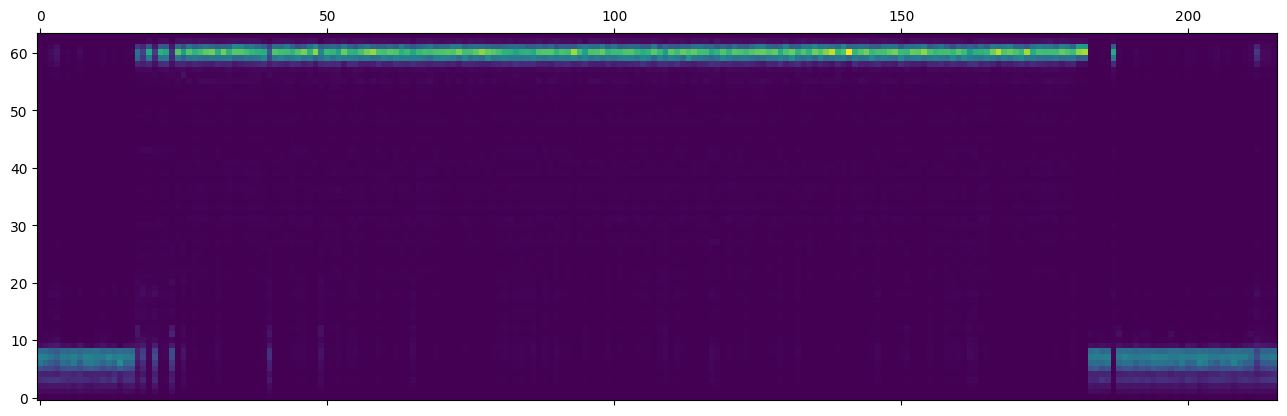

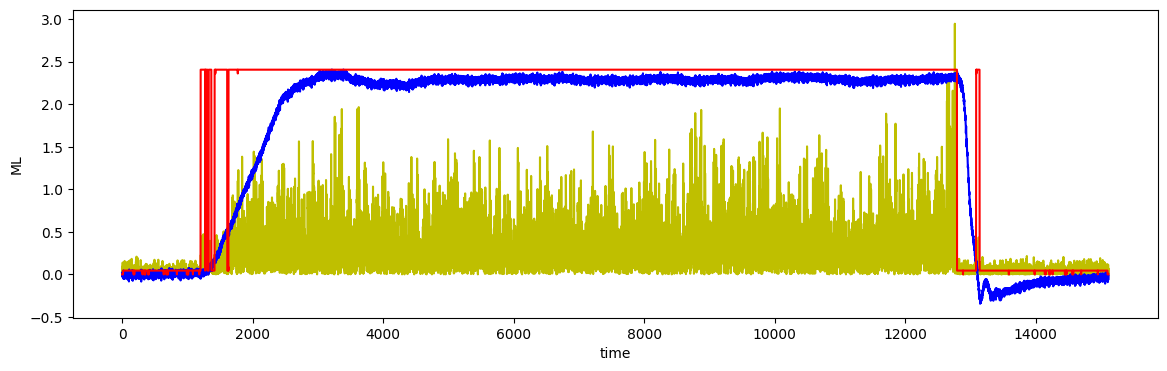

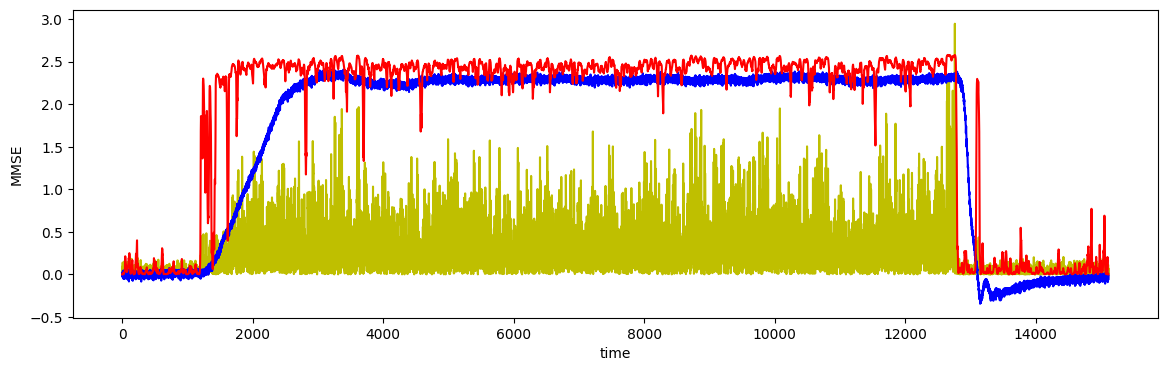

In [21]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 30  #pl means the same as always
predict_point = 15   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 8 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 80, conv_window = 2, conv_units = 10

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 79, 10)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 790)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        50,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,654 (197.87 KB)

 Trainable params: 50,654 (197.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15036/15036 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 2.3930
Epoch 2/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 2.0713
Epoch 3/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0211
Epoch 4/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 1.9833
Epoch 5/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.9618
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.49780616680311895
MMSE rms_error 0.4650667592042333


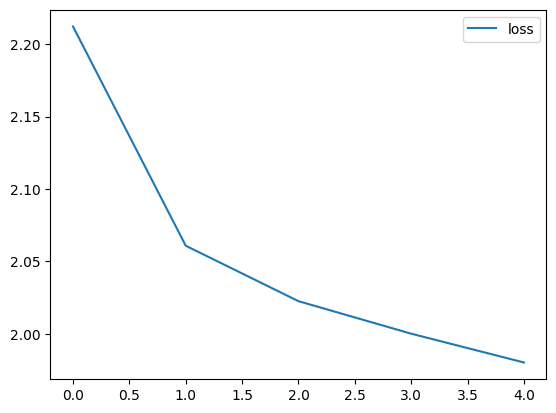

<Figure size 1400x400 with 0 Axes>

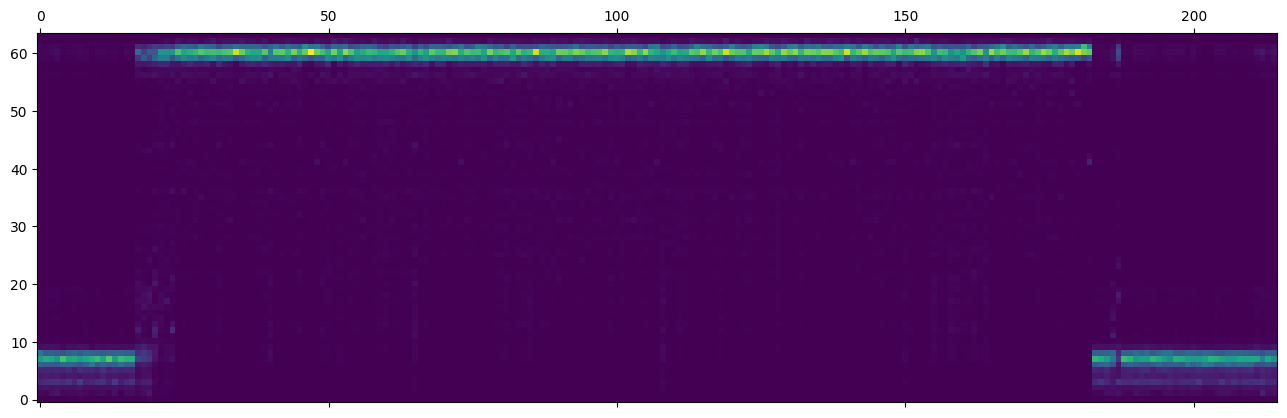

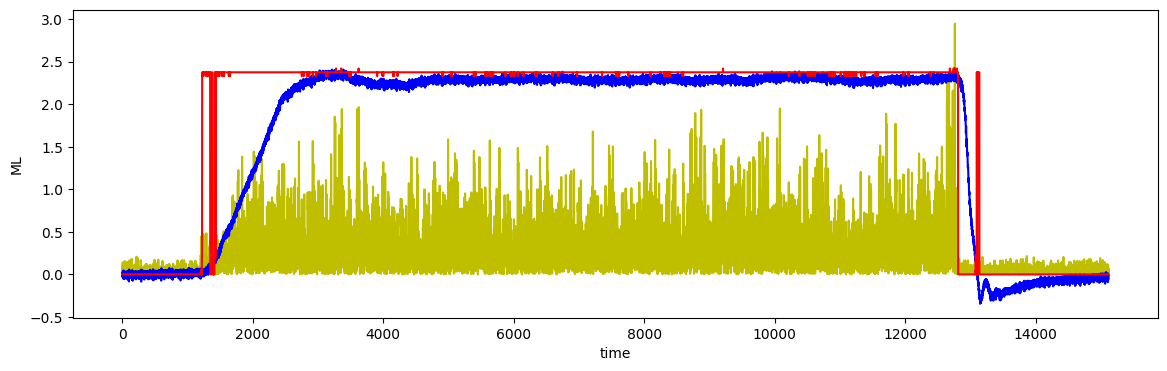

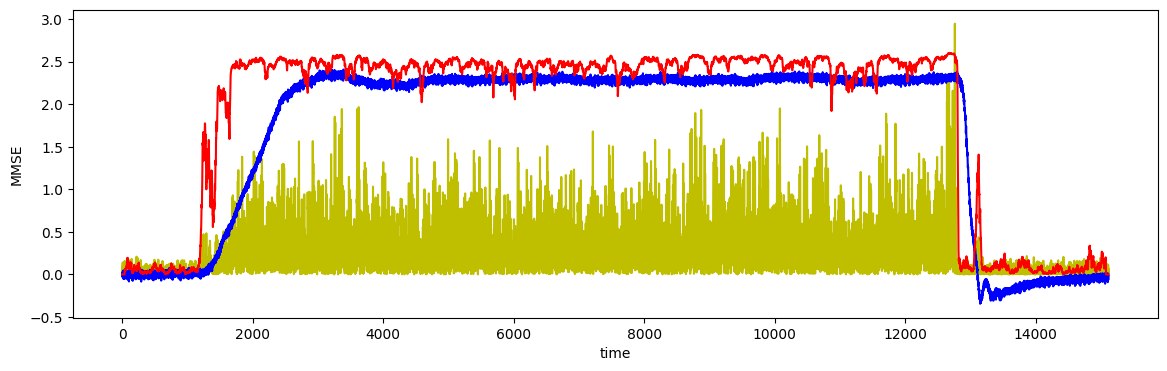

In [22]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 80  #pl means the same as always
predict_point = 40   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 50, conv_window = 2, conv_units = 40

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 49, 40)         │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       125,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,624 (490.72 KB)

 Trainable params: 125,624 (490.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15066/15066 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.6319
Epoch 2/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.1427
Epoch 3/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0693
Epoch 4/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0321
Epoch 5/5
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0230
15066/15066 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5221111135474947
MMSE rms_error 0.48131554037994545


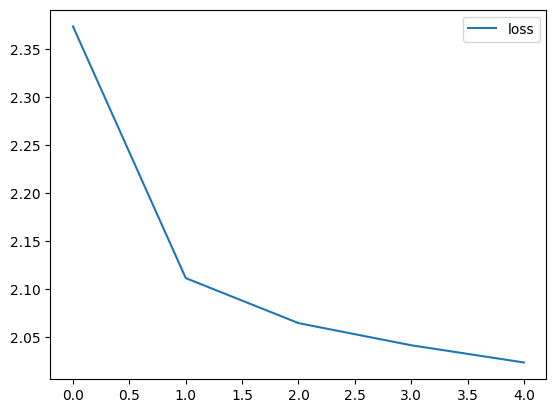

<Figure size 1400x400 with 0 Axes>

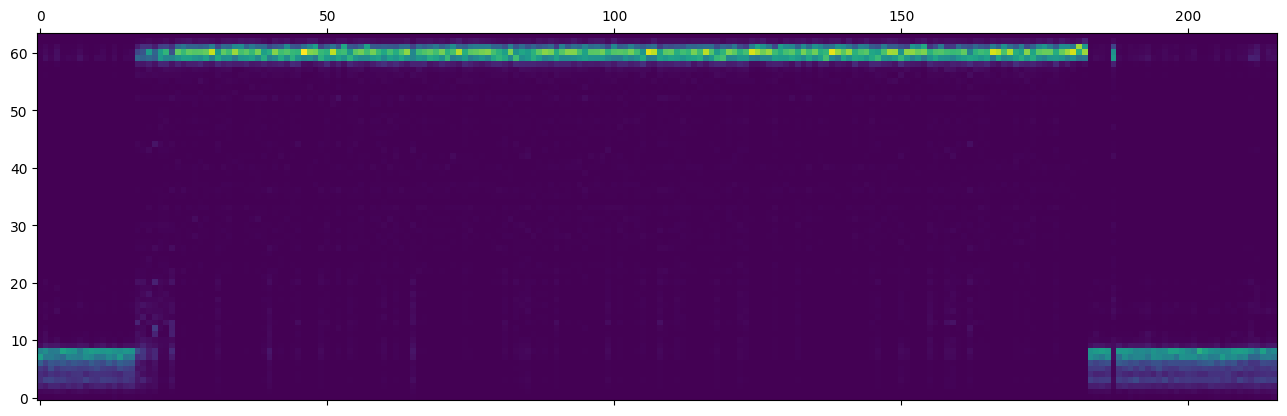

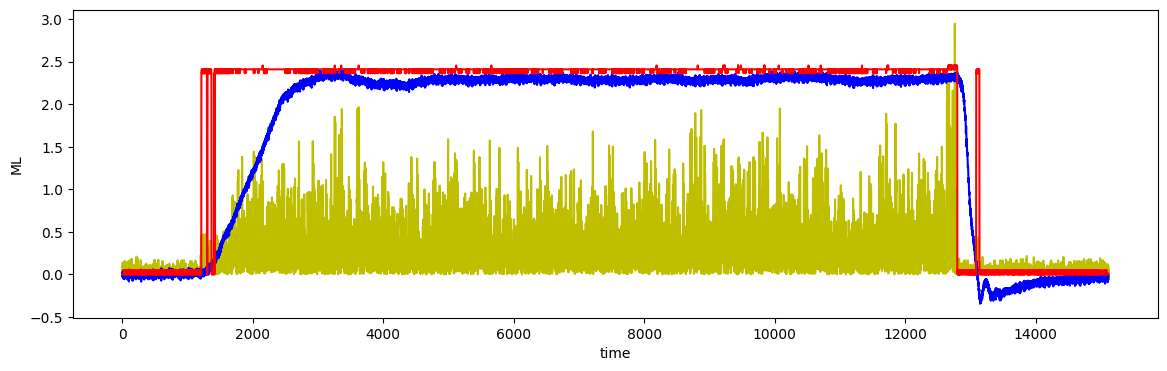

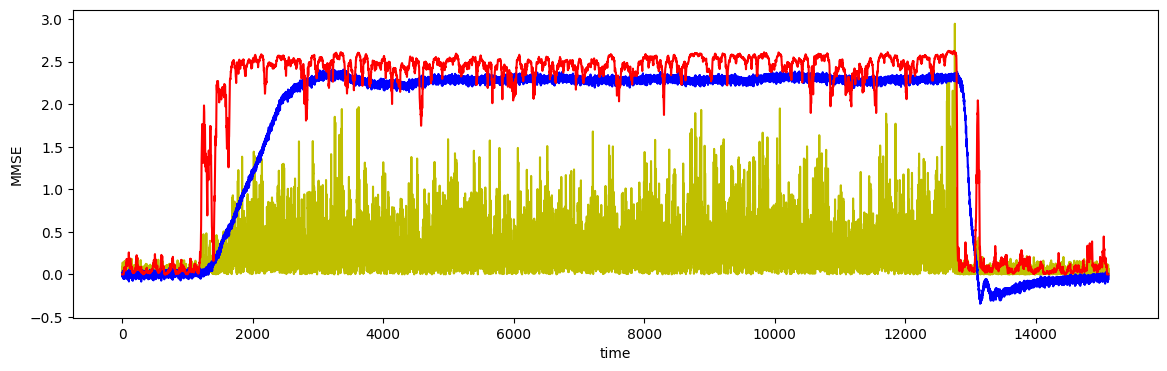

In [23]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 50  #pl means the same as always
predict_point = 25   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 2 #how many time points in the convolution kernel h
n_conv_units = 40   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

# Window Size = 80, conv_window = 10, conv_units = 10


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 71, 10)         │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 710)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        45,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,614 (178.18 KB)

 Trainable params: 45,614 (178.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15036/15036 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.3183
Epoch 2/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 2.0770
Epoch 3/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2.0441
Epoch 4/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.0073
Epoch 5/5
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.9682
15036/15036 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
ML rms_error 0.5952827315155766
MMSE rms_error 0.4581365618457837


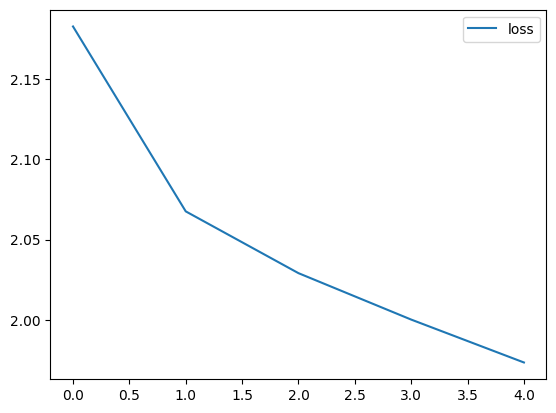

<Figure size 1400x400 with 0 Axes>

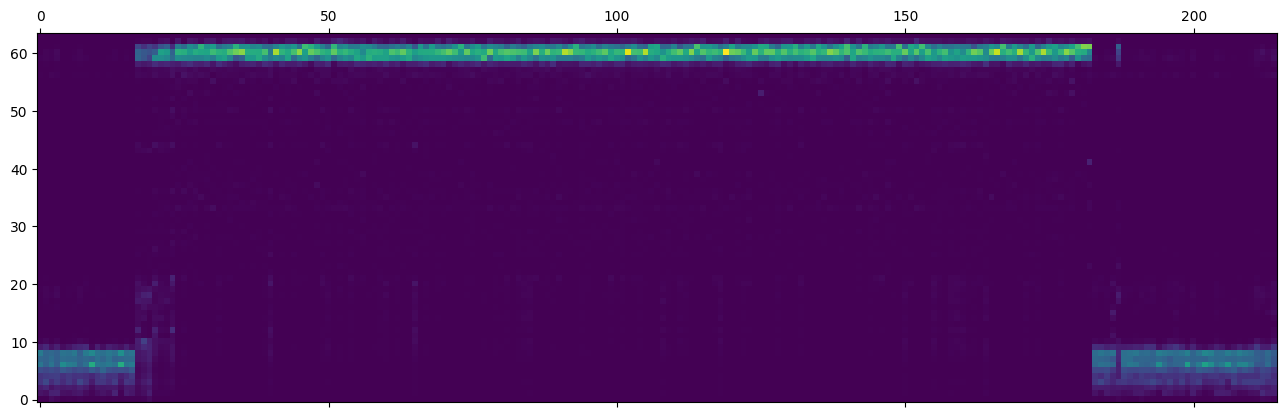

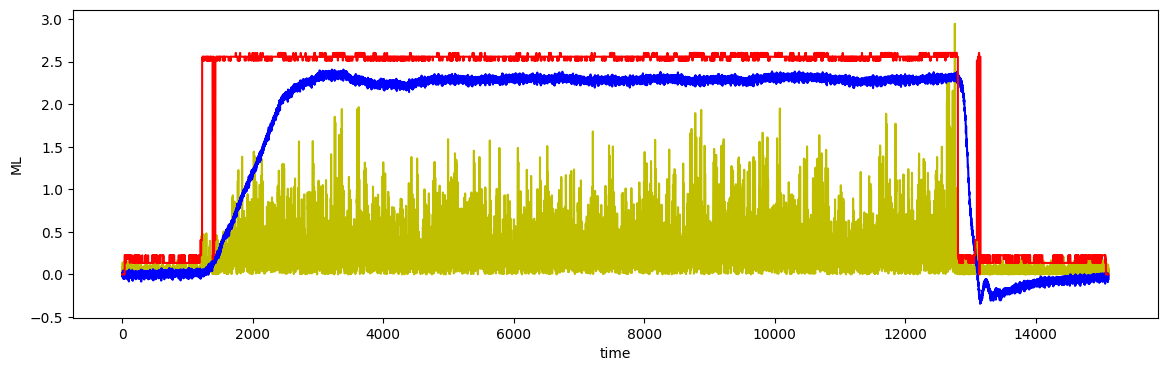

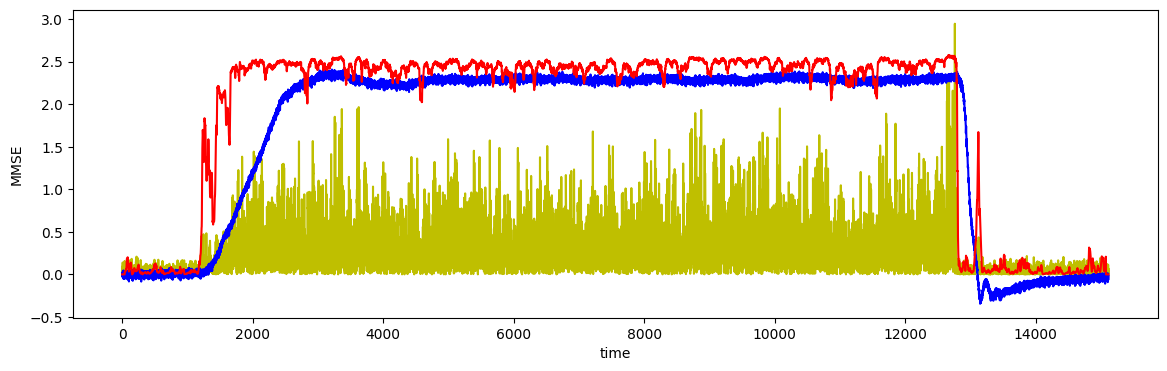

In [24]:
#generator will produce short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 80  #pl means the same as always
predict_point = 40   #half of predict_length => middle value
#make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)
#TimeSeriesGenerator always tries to predict the next point
#this corrects so that it is predicting the middle point.
#unlike in the Markov model, here we predict the true wave data
#from the measurement directly p(x|z)
generator = TimeseriesGenerator(modulated_signal, dfTarget.values,
                                length = predict_length, batch_size=batch_size)
#don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)

#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape, Input
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
#useful for combining the outputs of convolution layers

window_size = predict_length #better to think of as a sliding window onto the input series
len_conv_window = 10 #how many time points in the convolution kernel h
n_conv_units = 10   #how many different convolution kernels h_i (dimension)
n_sensors = 1       #in this case, we just use a single sensor from the biceps.
#n_sensors here is the n_features equivalent. Dimension of 1 (scalar)
model = Sequential()
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Input((predict_length,n_sensors)))
#input is (batch_size, predict_length, n_sensors); figures out batch_size for itself
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten()) #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax')) #one-hot output encoding with n_states
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

#train
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)

#because we used a distributed (one-hot) output encoding,
#need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)

#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));